In [1]:
# Importing the libraries
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots
plt.style.use('fivethirtyeight')

# !pip yfinance
import yfinance as yf

# !pip install ta
from ta import * # like any other bad programemr would do... 
import ta 

import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
consider_every_Nth_day = 10 # used in CCI loops only. 10 means biweekly (10 trading days in 2 weeks)
invPerTimePeriod = 1000 / 20 # ration your 1000 per month every day
STOCK = 'SPY'

In [3]:
start="2017-01-01"
start="2003-3-14"
start="2000-01-01"
df = yf.download(STOCK, start) 
# df = df.drop(columns=['Open','High', 'Low','Adj Close','Volume'])
df['MA'] = df.Close.rolling(window=5).mean().fillna(df.Close[0])
df.dropna(inplace=True)
df.head(3)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,MA
Date,,,,,,,
2000-01-03,148.25000,148.25000,143.875000,145.4375,93.881943,8164300,145.4375
2000-01-04,143.53125,144.06250,139.640625,139.7500,90.210571,8089800,145.4375
2000-01-05,139.93750,141.53125,137.250000,140.0000,90.371948,12177900,145.4375


Text(0.5, 0.98, 'Compare Window size window')

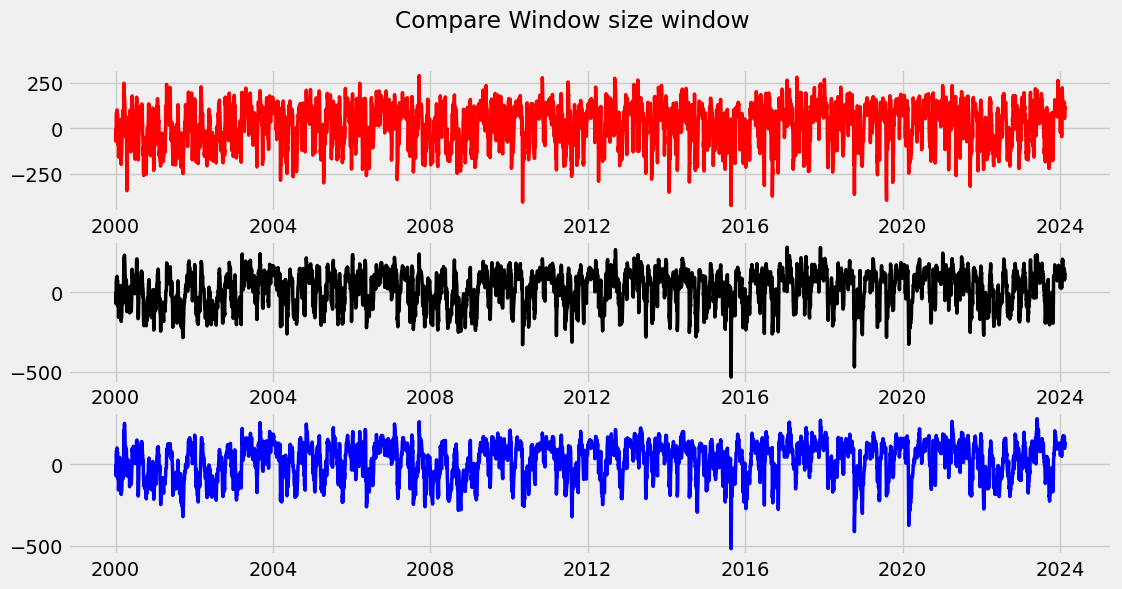

In [4]:
C = 0.015 # 0.015
cci2 = ta.trend.cci(high=df.High, low=df.Low, close=df.Close, window=20, constant=C, fillna=True) # 'n' is now 'window'; 'c' is not 'constant'... damn API changes. current version on ta broke several notebooks. This is why I rerun past code every few years 
cci3 = ta.trend.cci(high=df.High, low=df.Low, close=df.Close, window=30, constant=C, fillna=True)
cci4 = ta.trend.cci(high=df.High, low=df.Low, close=df.Close, window=40, constant=C, fillna=True)


fig, axs = plt.subplots(3, figsize=(12,6))
fig.suptitle('Compare Window size window')


_=axs[0].plot(cci2, color='r', linewidth=2.5) #, alpha = 1.0)
_=axs[1].plot(cci3, color='k', linewidth=2.5) #, alpha = 1.0)
_=axs[2].plot(cci4, color='b', linewidth=2.5) #, alpha = 0.85)
plt.show()

In [5]:
df["cci"] = cci4
df.head(5)

,Open,High,Low,Close,Adj Close,Volume,MA,cci
Date,,,,,,,,
2000-01-03,148.25000,148.25000,143.875000,145.4375,93.881943,8164300,145.4375,0.000000
2000-01-04,143.53125,144.06250,139.640625,139.7500,90.210571,8089800,145.4375,-66.666667
2000-01-05,139.93750,141.53125,137.250000,140.0000,90.371948,12177900,145.4375,-71.306413
2000-01-06,139.62500,141.50000,137.750000,137.7500,88.919533,6227200,145.4375,-71.830849
2000-01-07,140.31250,145.75000,140.062500,145.7500,94.083664,8066500,141.7375,55.213825


## Plot days in which the CCI is > N

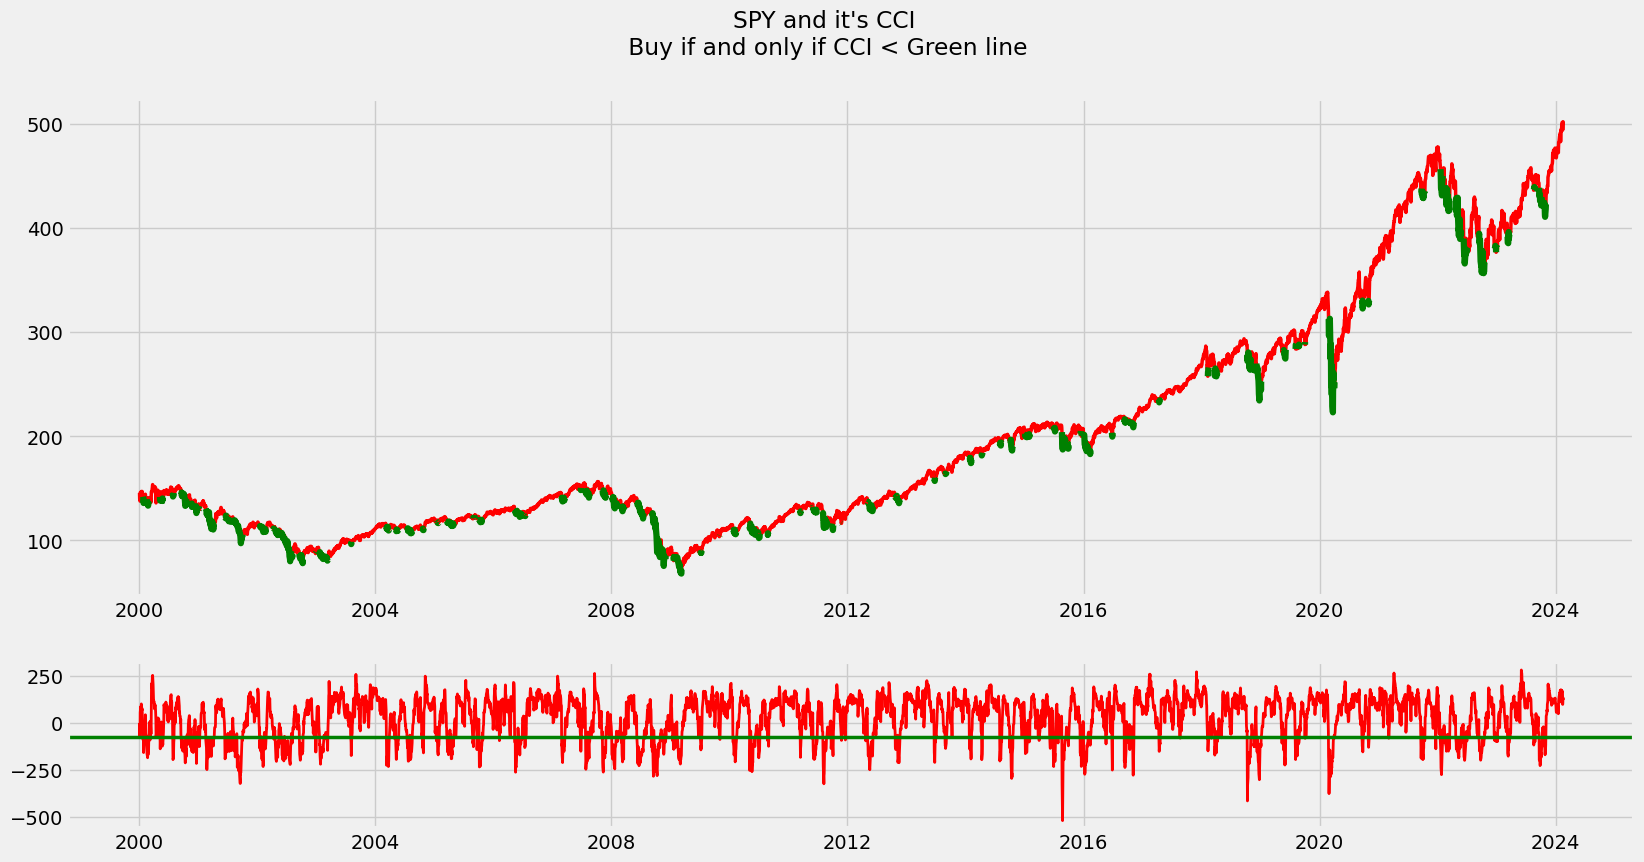

In [14]:
def plot_stock_cci_over_under(lowerBound=-100, upperBound=100, dataset=df):
    #dataset = dataset.copy()
    tmp = dataset[(dataset['cci'] > lowerBound) & (dataset['cci'] < upperBound)]
    a = set(dataset.index.values)
    b = set(tmp.index.values)
    idx_in_market = list(a-b)
    
    dataset['day_in_market'] = dataset.loc[idx_in_market].sort_index()['Close']
    
#     dataset[['Close', 'day_in_market']].plot(figsize=(18, 6), title='You only buy more stock on the blue days. Never sell')
    
    fig, axs = plt.subplots(2, gridspec_kw={'height_ratios': [3, 1]}) # , figsize=(24, 9)
    fig.suptitle(f"{STOCK.upper()} and it's CCI\n Buy if and only if CCI < Green line")
    fig.set_figheight(9)
    fig.set_figwidth(18)
    axs[0].plot(dataset['Close'], color='red', linewidth=2.5, label='price') #, alpha = 1.0)
    axs[0].plot(dataset['day_in_market'], color='green', linewidth=4.5, label='day_in_market') #, alpha = 1.0)
    axs[1].plot(dataset['cci'], color='red', linewidth=2.0, label='cci') #, alpha = 1.0)
    axs[1].axhline(lowerBound, linewidth=2.5, color="green")


#     plt.legend()
#     fig.show()

plot_stock_cci_over_under(-75, float('inf'))

## Buy and Hold

In [8]:
base_strategy = 0 # Total base strategy
shares = 0 

for i, row in df.iterrows():
    shares += invPerTimePeriod/row.Close
    # print("shares:" , shares)

base_strategy = round(df.tail(1).Close.values[0]*shares, 2)
print(f"Numb of shares: {shares:.2f}")
print(f"Value of Shares: {base_strategy:.2f}")

Numb of shares: 1926.96
Value of Shares: 962535.88


## Double for loop pram optimization

In [15]:
def CCIStrat(dataset=df):
  dataset = dataset.copy().iloc[0::consider_every_Nth_day] #[1::20] start at 1, every 20th (monthly)
  
  invPerTimePeriod_skip = invPerTimePeriod * consider_every_Nth_day

  step_size = 20
  cci_min = int(dataset['cci'].min())
  cci_max = int(dataset['cci'].max())

  top_total = 0
  top_min = 0
  top_max = 0
  for max in np.arange(cci_min, cci_max, step_size): # -200+step_size
    print(f'\nmax is {max} min is', end="")
    for min in np.arange(cci_min, max, step_size):
        print(f', {min}', end="")
        total = 0
        shares = 0 
        moneyToInvest = 0
        for i in dataset.index:
            moneyToInvest += invPerTimePeriod_skip
            cci = dataset.loc[i].at['cci']
            close = dataset.loc[i].at['Close']

            if(cci > max):
                #sell
                moneyToInvest += (close * shares)
                shares=0

            if(cci< min): # or np.isnan(Cci) # prevents exactly "buy and hold" as for the first 40 days (2 iterations) cci is NaN
                #buy 
                numShares = math.floor((moneyToInvest)/close)
                shares += numShares
                moneyToInvest -= (close * numShares)

            
            #end of innerloop 
        
        total = int(dataset.tail(1).Close*shares+moneyToInvest)
        if(total > top_total):
            top_total = total
            top_min, top_max = min, max 
  #print("num of shares * last closing ",int(dataset.tail(1).Close*shares)) #dataset.tail, not df2.tail
  #print("total: ", (int(dataset.tail(1).Close*shares)+moneyToInvest))
  print("=======================================")
  print(f"min: {top_min} | max: {top_max} | total: {top_total}")
  print(f"base_strategy: {base_strategy:.2f}")
#   return int(dataset.tail(1).Close*shares+moneyToInvest)

resultOfCCStrat = CCIStrat()


max is -375 min is
max is -355 min is, -375
max is -335 min is, -375, -355
max is -315 min is, -375, -355, -335
max is -295 min is, -375, -355, -335, -315
max is -275 min is, -375, -355, -335, -315, -295
max is -255 min is, -375, -355, -335, -315, -295, -275
max is -235 min is, -375, -355, -335, -315, -295, -275, -255
max is -215 min is, -375, -355, -335, -315, -295, -275, -255, -235
max is -195 min is, -375, -355, -335, -315, -295, -275, -255, -235, -215
max is -175 min is, -375, -355, -335, -315, -295, -275, -255, -235, -215, -195
max is -155 min is, -375, -355, -335, -315, -295, -275, -255, -235, -215, -195, -175
max is -135 min is, -375, -355, -335, -315, -295, -275, -255, -235, -215, -195, -175, -155
max is -115 min is, -375, -355, -335, -315, -295, -275, -255, -235, -215, -195, -175, -155, -135
max is -95 min is, -375, -355, -335, -315, -295, -275, -255, -235, -215, -195, -175, -155, -135, -115
max is -75 min is, -375, -355, -335, -315, -295, -275, -255, -235, -215, -195, -175, 

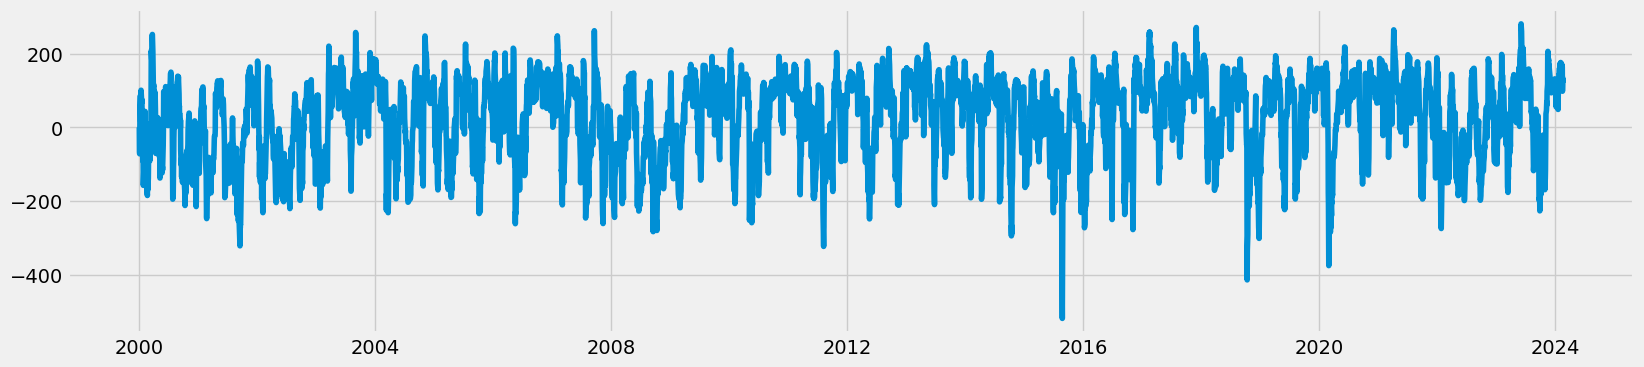

In [10]:
fig=plt.figure(figsize=(18,4))
plt.plot(df.cci)
plt.show()

# TODO add pics below

In [11]:
def noSelling(upper = 100, lower = -100, allow_sell=False, plot=False):
    dataset = df.copy()    
    dataset = dataset.iloc[0::consider_every_Nth_day]
    invPerTimePeriod_skip = invPerTimePeriod * consider_every_Nth_day # DAILY $ * N days


    total =0
    shares=0 
    moneyToInvest = invPerTimePeriod_skip
    for i in dataset.index:
        cci = dataset.loc[i].at['cci']
        close = dataset.loc[i].at['Close']

        if(cci > upper and allow_sell):
#           # sell
            moneyToInvest += (close * shares)
            shares=0
            print('sold')

        if(cci < lower): # or np.isnan(Cci) # prevents exactly "buy and hold" as for the first 40 days (2 iterations) cci is NaN
            # buy 
            numb_shares_buying = math.floor(moneyToInvest/close)
            shares+=numb_shares_buying
            moneyToInvest -= (close * numb_shares_buying)

        moneyToInvest += invPerTimePeriod_skip
    
    total = int(dataset.tail(1).Close*shares + moneyToInvest)

    if allow_sell==False:
        print(f'CCI to buy {lower}.')
    else:
        print(f'CCI to buy-sell range {lower} - {upper}.')

    print(f"Total money made: {total:.2f} compared to {base_strategy:.2f}.\nThat's a {100*(total-base_strategy)/base_strategy:.6f}% change\n")
    
    if plot:
        fig, axs = plt.subplots(2, gridspec_kw={'height_ratios': [3, 1]}) # , figsize=(24, 9)
        fig.suptitle('foobar')
        fig.set_figheight(9)
        fig.set_figwidth(24)
        axs[0].plot(dataset['Close'], color='k', linewidth=2.5) #, alpha = 1.0)
        axs[1].plot(dataset['cci'], color='r', linewidth=2.5) #, alpha = 1.0)
        axs[1].axhline(lower, linewidth=2.5)
        axs[1].axhline(upper, linewidth=2.5)
        fig.show()

# noSelling(upper = 100, lower = -100)
# noSelling(upper = 110, lower = -60)
# noSelling(upper = 90, lower = -30)
# noSelling(upper = 90, lower = 0)

noSelling(upper = 99999, lower = -30, plot=False)
noSelling(upper = 99999, lower = 0)
noSelling(upper = 99999, lower = -75)
noSelling(upper = 99999, lower = -150)
noSelling(upper = 99999, lower = -200)

CCI to buy -30.
Total money made: 947921.00 compared to 962535.88.
That's a -1.518372% change

CCI to buy 0.
Total money made: 946890.00 compared to 962535.88.
That's a -1.625485% change

CCI to buy -75.
Total money made: 949819.00 compared to 962535.88.
That's a -1.321185% change

CCI to buy -150.
Total money made: 925150.00 compared to 962535.88.
That's a -3.884102% change

CCI to buy -200.
Total money made: 887791.00 compared to 962535.88.
That's a -7.765412% change



(6070, 9)


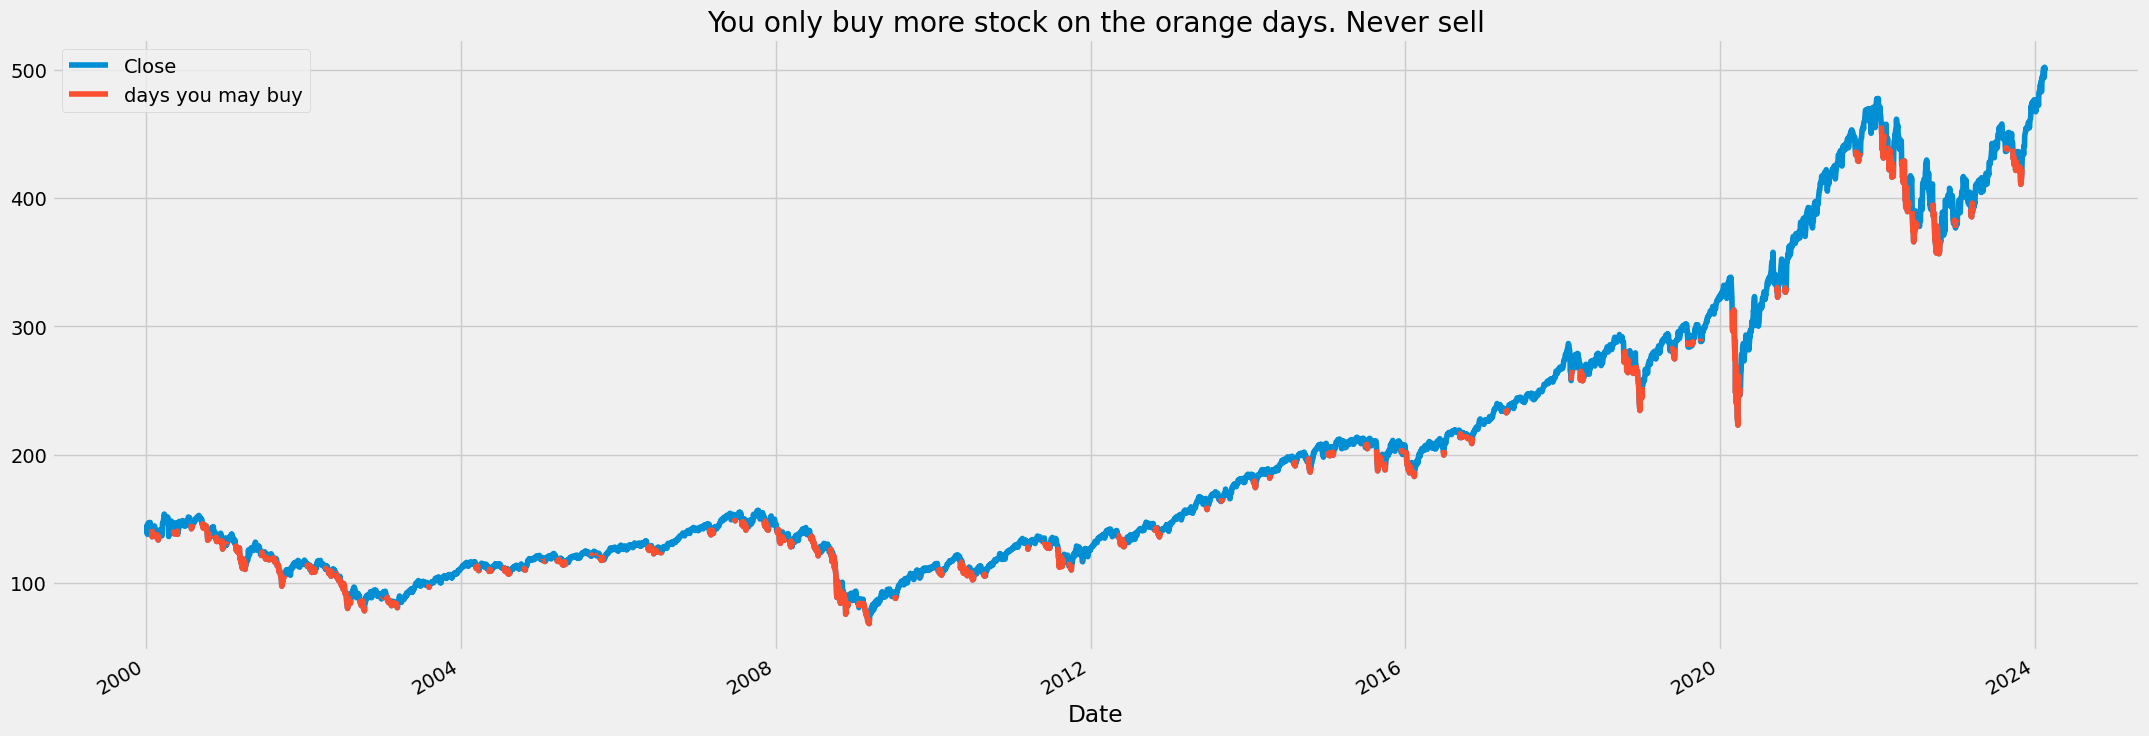

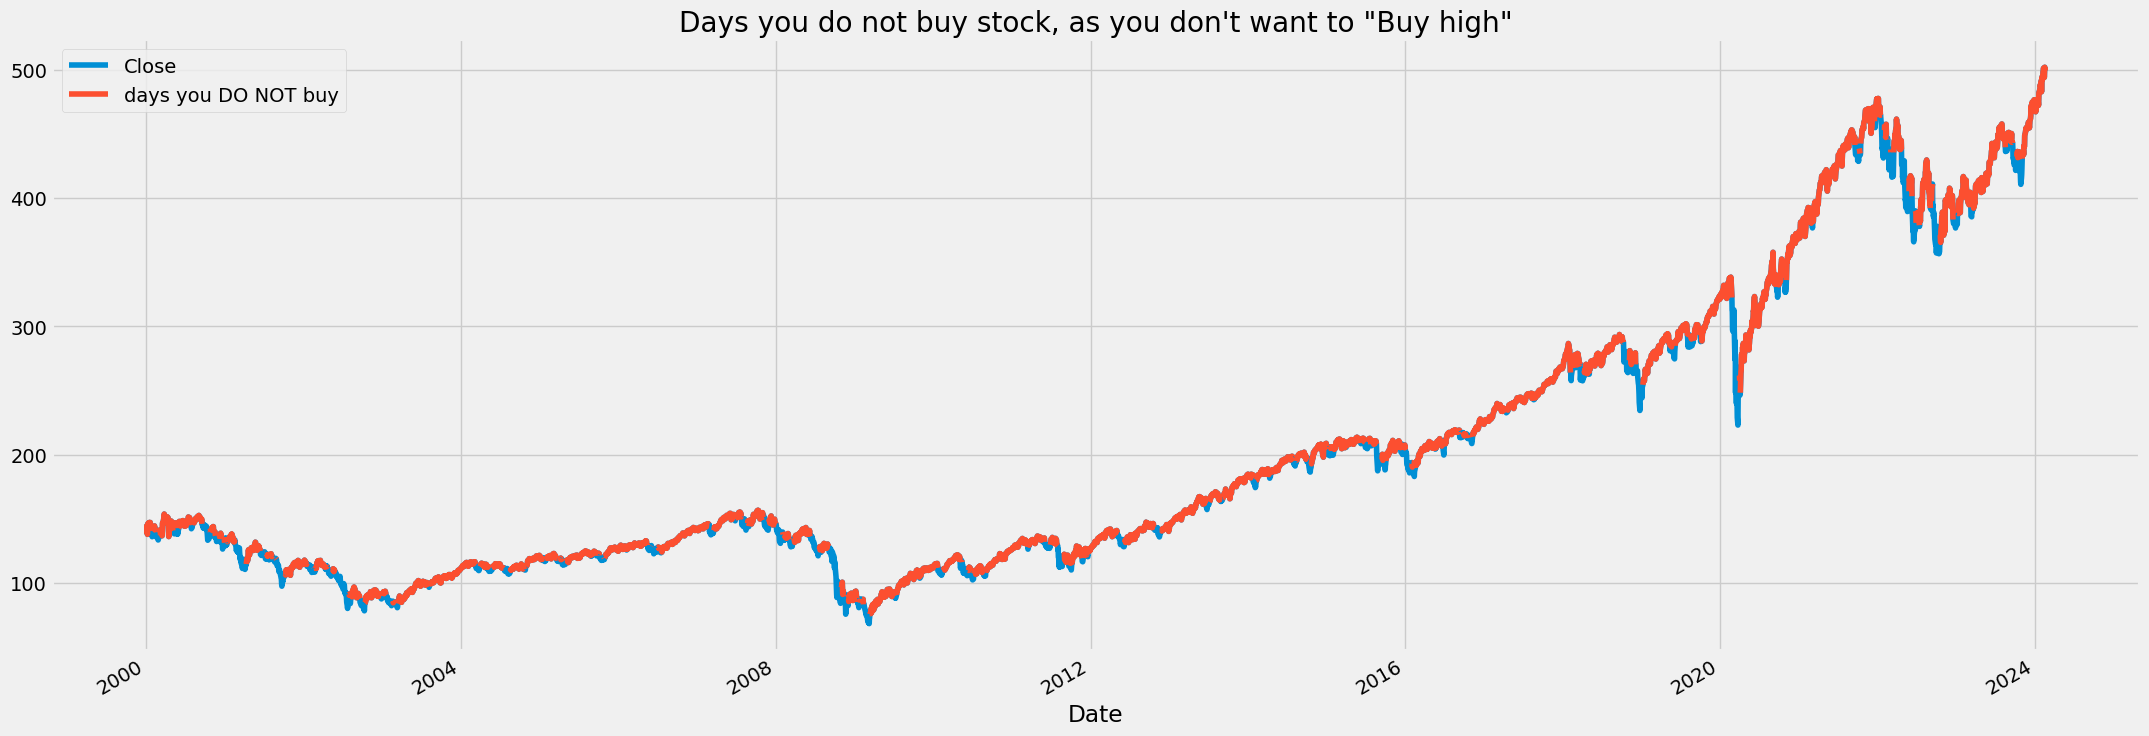

In [12]:
CCI_to_buy_below = -75
print(df.shape)

tmp = df[df['cci'] > CCI_to_buy_below]

a = set(df.index.values)
b = set(tmp.index.values)
idx_in_market = list(a-b)
df['days you may buy'] = df.loc[idx_in_market].sort_index()['Close']
df[['Close', 'days you may buy']].plot(figsize=(24, 9), title='You only buy more stock on the orange days. Never sell');


tmp = df[df['cci'] < CCI_to_buy_below]

a = set(df.index.values)
b = set(tmp.index.values)
idx_in_market = list(a-b)
df['days you DO NOT buy'] = df.loc[idx_in_market].sort_index()['Close']
df[['Close', 'days you DO NOT buy']].plot(figsize=(24, 9), title='Days you do not buy stock, as you don\'t want to \"Buy high\"');

     [Where selling is not permitted]
What if we did buy and hold?, 962535.88	 That's a -0.015720% change



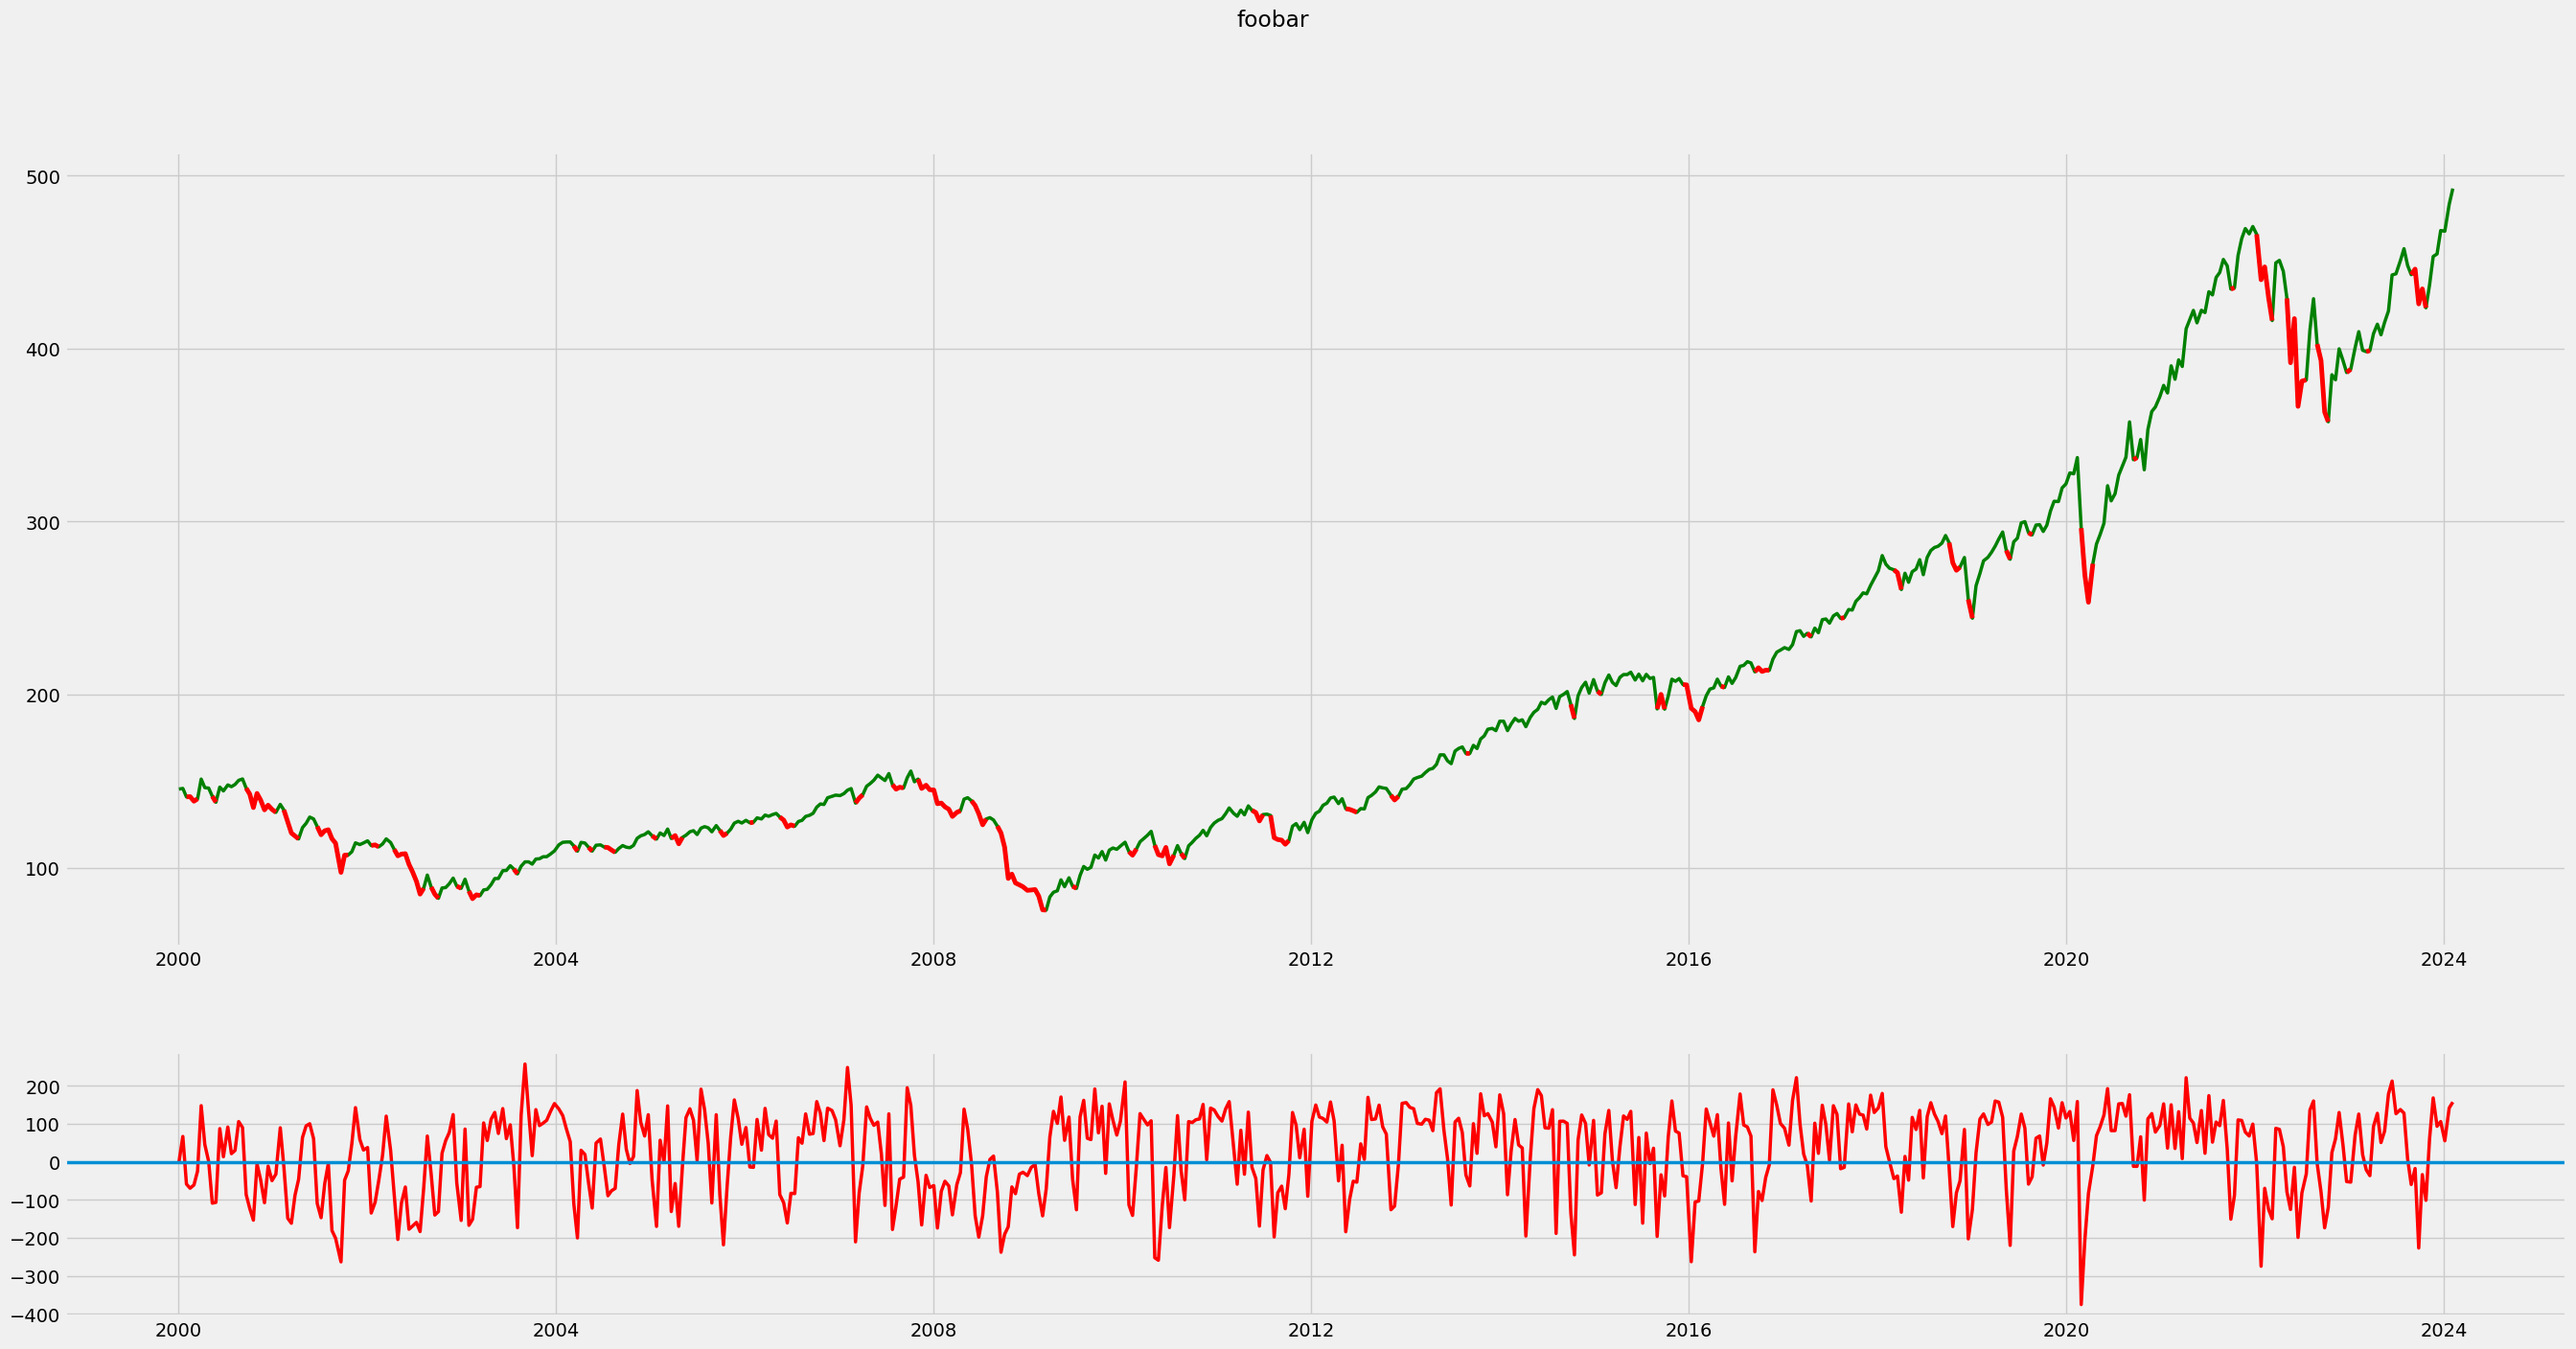

In [16]:
def CCI_center_point(allow_sell=True, plot=False):
    dataset = df.copy()    
    dataset = dataset.iloc[0::consider_every_Nth_day]
    invPerTimePeriod_skip = invPerTimePeriod * consider_every_Nth_day # DAILY $ * N days
    total = 0
    shares = 0 
    moneyToInvest = invPerTimePeriod_skip
    for i in dataset.index:
        cci = dataset.loc[i].at['cci']
        close = dataset.loc[i].at['Close']

        if(cci < 0 and allow_sell):
            #sell
            moneyToInvest += (close * shares)
            shares=0
            print('sold')


        if(cci > 0): # or np.isnan(Cci) # prevents exactly "buy and hold" as for the first 40 days (2 iterations) cci is NaN
            #buy 
            numShares = math.floor(moneyToInvest/close)
            shares+=numShares
            moneyToInvest -= (close.round(2) * numShares)

        moneyToInvest += invPerTimePeriod_skip
    #end of innerloop 
    total = int(dataset.tail(1).Close*shares + moneyToInvest)

    if allow_sell==False:
        print(f'     [Where selling is not permitted]')
    else:
        print(f"Total money made: {total}. Can buy anytime below a CCI of 0")
    
    print(f"What if we did buy and hold?, {base_strategy:.2f}\t That's a {(total-base_strategy)/base_strategy:.6f}% change")
    print(f"")
    
    if plot:
        fig, axs = plt.subplots(2, gridspec_kw={'height_ratios': [3, 1]}) # , figsize=(24, 15)
        fig.suptitle('foobar')
        fig.set_figwidth(30)
        fig.set_figheight(15)
        
        
        negative = dataset[dataset['cci'] < 0]
        idx_in_market = negative.index.values
        dataset['days you may buy'] = dataset.loc[idx_in_market].sort_index()['Close']
        #dataset[['Close', 'days you may buy']].plot(figsize=(24, 9), title='You only buy more stock on the orange days. Never sell');
        
        axs[0].plot(dataset['Close'], color='g', linewidth=2.5) #, alpha = 1.0)
        axs[0].plot(dataset['days you may buy'], color='r', linewidth=3.5) #, alpha = 1.0)
        axs[1].plot(dataset['cci'], color='r', linewidth=2.5) #, alpha = 1.0)
        axs[1].axhline(0, linewidth=2.5)
        fig.show()

CCI_center_point(allow_sell=False, plot=True)